In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
train_data = load_pickle_data("Train_stft_features.pkl")
val_data = load_pickle_data("Val_stft_features.pkl")
test_data = load_pickle_data("Test_stft_features.pkl")

## Pre-processing

# EDA

In [4]:
def extract_features_to_df(data):
    features = [np.concatenate([
        np.mean(item['stft'], axis=1),
        np.var(item['stft'], axis=1),
        np.max(item['stft'], axis=1),
    ]) for item in data]

    df_features = pd.DataFrame(features)

    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    return df_scaled

df_train = extract_features_to_df(train_data)
df_val = extract_features_to_df(val_data)
df_test = extract_features_to_df(test_data)

corr_train = df_train.corr()
corr_val = df_val.corr()
corr_test = df_test.corr()


In [6]:
df_train.shape[1]

771

In [5]:
df_train["dataset_type"] = "train"
df_val["dataset_type"] = "val"
df_test["dataset_type"] = "test"

df_full = pd.concat([df_train, df_val, df_test], ignore_index=True)

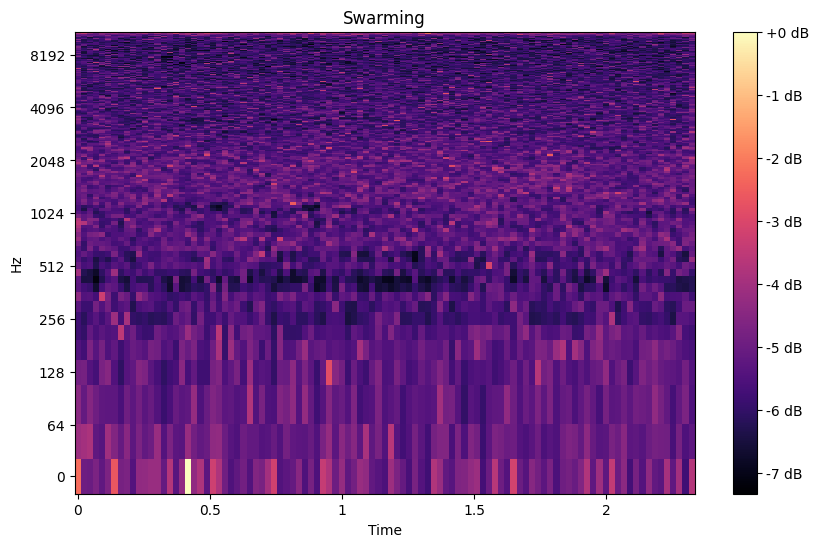

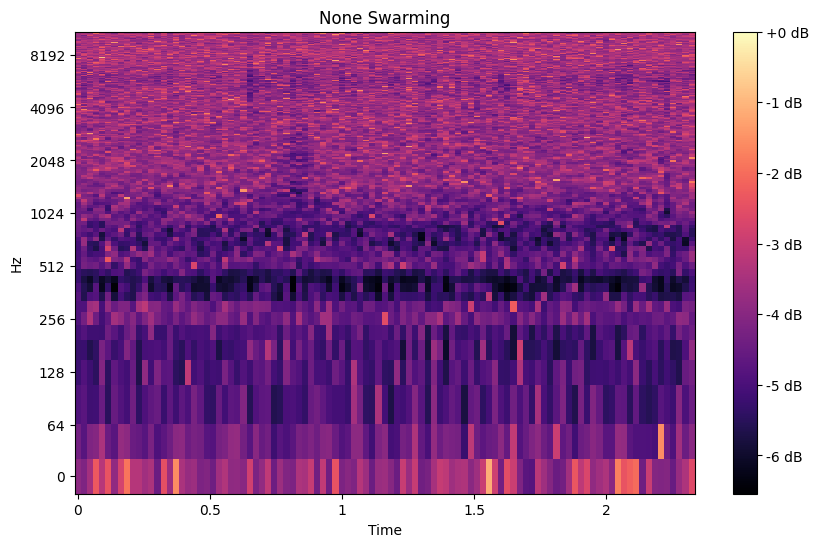

In [14]:
import matplotlib.pyplot as plt
import librosa.display
import random

def plot_spectrogram(data, title):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(data, ref=np.max), y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

swarming_sample = random.choice([item['stft'] for item in train_data if item['category'] == 'Swarming'])
none_swarming_sample = random.choice([item['stft'] for item in train_data if item['category'] == 'None_swarming'])

plot_spectrogram(swarming_sample, 'Swarming')
plot_spectrogram(none_swarming_sample, 'None Swarming')


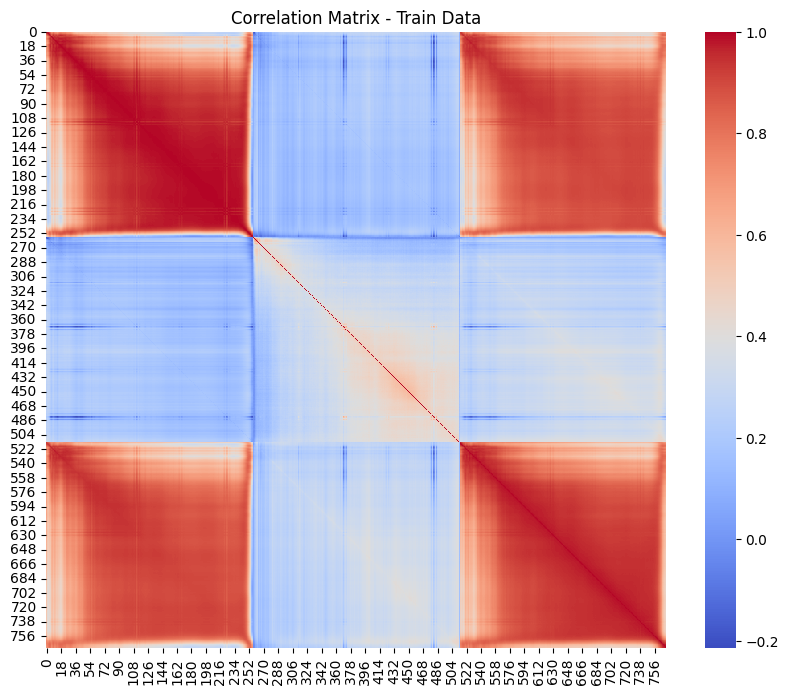

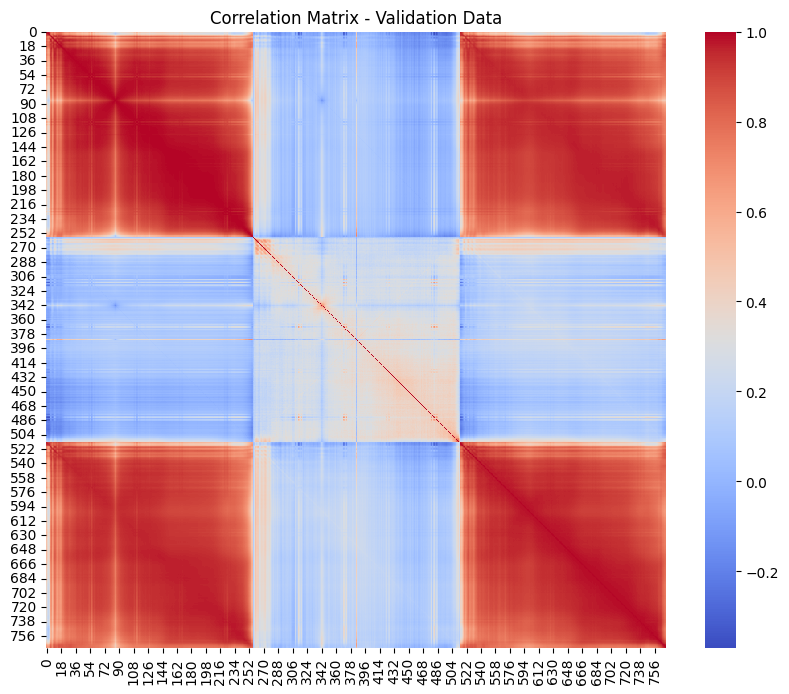

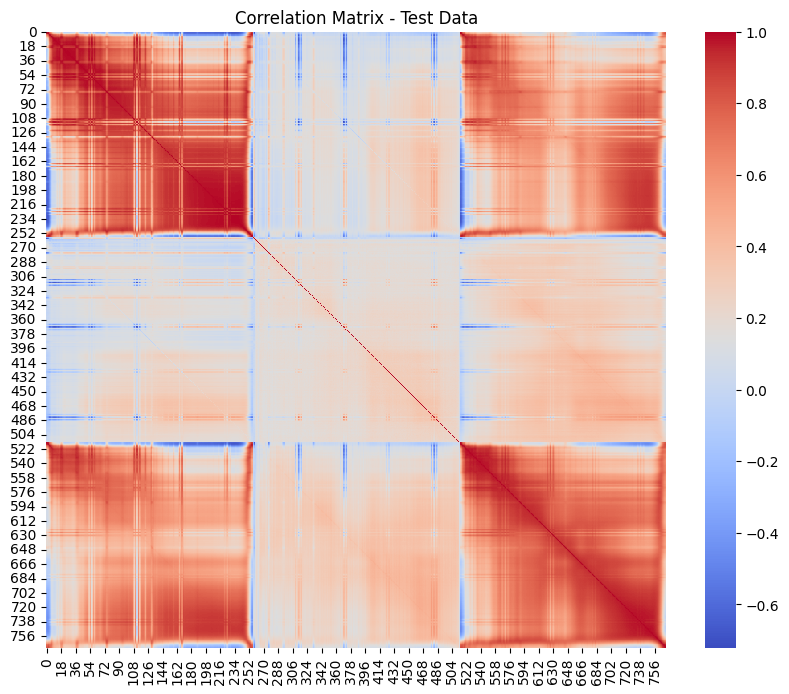

In [7]:
# Vẽ heatmap cho tập Train
plt.figure(figsize=(10, 8))
sns.heatmap(corr_train, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Train Data")
plt.show()

# Vẽ heatmap cho tập Validation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_val, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Validation Data")
plt.show()

# Vẽ heatmap cho tập Test
plt.figure(figsize=(10, 8))
sns.heatmap(corr_test, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix - Test Data")
plt.show()


In [ ]:
df_numeric = df_train.select_dtypes(include=[np.number])

corr_train = df_numeric.corr().abs()

high_corr_features = np.where(corr_train > 0.9)
high_corr_pairs = [(df_numeric.columns[i], df_numeric.columns[j], corr_train.iloc[i, j])
                   for i, j in zip(*high_corr_features) if i != j]

seen = set()
filtered_pairs = []
for col1, col2, corr_value in high_corr_pairs:
    if (col2, col1) not in seen:
        seen.add((col1, col2))
        filtered_pairs.append((col1, col2, corr_value))

print("Các cặp đặc trưng số có tương quan cao (corr > 0.9):")
for col1, col2, corr_value in filtered_pairs:
    print(f"{col1} ↔ {col2}: {corr_value:.4f}")

Các cặp đặc trưng số có tương quan cao (corr > 0.9):
0 ↔ 1: 0.9674
0 ↔ 2: 0.9046
0 ↔ 514: 0.9246
0 ↔ 515: 0.9228
1 ↔ 2: 0.9688
1 ↔ 3: 0.9029
1 ↔ 515: 0.9270
1 ↔ 516: 0.9218
2 ↔ 3: 0.9585
2 ↔ 515: 0.9057
2 ↔ 516: 0.9371
2 ↔ 517: 0.9108
3 ↔ 4: 0.9662
3 ↔ 5: 0.9328
3 ↔ 8: 0.9157
3 ↔ 9: 0.9029
3 ↔ 16: 0.9042
3 ↔ 17: 0.9128
3 ↔ 18: 0.9085
3 ↔ 516: 0.9144
3 ↔ 517: 0.9485
3 ↔ 518: 0.9361
3 ↔ 519: 0.9016
4 ↔ 5: 0.9674
4 ↔ 7: 0.9071
4 ↔ 8: 0.9494
4 ↔ 9: 0.9360
4 ↔ 10: 0.9072
4 ↔ 11: 0.9198
4 ↔ 12: 0.9332
4 ↔ 13: 0.9095
4 ↔ 14: 0.9110
4 ↔ 15: 0.9382
4 ↔ 16: 0.9520
4 ↔ 17: 0.9584
4 ↔ 18: 0.9567
4 ↔ 19: 0.9490
4 ↔ 20: 0.9434
4 ↔ 21: 0.9312
4 ↔ 22: 0.9231
4 ↔ 23: 0.9269
4 ↔ 24: 0.9116
4 ↔ 517: 0.9241
4 ↔ 518: 0.9568
4 ↔ 519: 0.9263
4 ↔ 522: 0.9191
4 ↔ 523: 0.9119
4 ↔ 526: 0.9117
4 ↔ 529: 0.9121
4 ↔ 530: 0.9255
4 ↔ 531: 0.9310
4 ↔ 532: 0.9298
4 ↔ 533: 0.9229
4 ↔ 534: 0.9164
5 ↔ 6: 0.9441
5 ↔ 7: 0.9420
5 ↔ 8: 0.9595
5 ↔ 9: 0.9616
5 ↔ 10: 0.9468
5 ↔ 11: 0.9454
5 ↔ 12: 0.9524
5 ↔ 13: 0.9448
5 ↔ 14: 0.9

In [ ]:
print(f"Tổng số cặp đặc trưng có tương quan cao: {len(filtered_pairs)}")

Tổng số cặp đặc trưng có tương quan cao: 53214


# SVM (Support vector machine)

In [10]:
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)

    return np.concatenate([mean_stft, var_stft, max_stft])

X_train, y_train = [], []
for item in train_data:
    stft = item['stft']
    label = item['category']
    X_train.append(extract_features(stft))
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val, y_val = [], []
for item in val_data:
    stft = item['stft']
    label = item['category']
    X_val.append(extract_features(stft))
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print("Classification report for Validation Set:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

X_test, y_test = [], []
for item in test_data:
    stft = item['stft']
    label = item['category']
    X_test.append(extract_features(stft))
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Dự đoán trên tập Test
y_test_pred = svm_model.predict(X_test)

# Đánh giá mô hình trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification report for Test Set:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test}")
print(f"F1-Score (Test): {f1_test}")


Classification report for Validation Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.74      0.85      2200
     Swarming       0.80      1.00      0.89      2249

     accuracy                           0.87      4449
    macro avg       0.90      0.87      0.87      4449
 weighted avg       0.90      0.87      0.87      4449

Accuracy: 0.8714317824230164
F1-Score: 0.8690786771145782

Classification report for Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.58      0.73      5600
     Swarming       0.70      1.00      0.83      5600

     accuracy                           0.79     11200
    macro avg       0.85      0.79      0.78     11200
 weighted avg       0.85      0.79      0.78     11200

Accuracy (Test): 0.7901785714285714
F1-Score (Test): 0.7805157712594075


In [8]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Validation
    y_val_pred = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    print(f"Validation Accuracy: {accuracy_val:.4f}, F1-Score: {f1_val:.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test
    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Test Accuracy: {accuracy_test:.4f}, F1-Score: {f1_test:.4f}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Loại bỏ cột có tương quan cao
corr_matrix = X_train_df.corr().abs()
high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > 0.99]
best_cols_to_drop = set(j for _, j in high_corr)

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

print(f"Số lượng cột sau khi lọc: {X_train_final.shape[1]}")

# Các mô hình cần đánh giá
models = {
    'SVM': SVC(kernel='linear', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

# Đánh giá từng mô hình
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    evaluate_model(model, X_train_final, y_train, X_val_final, y_val, X_test_final, y_test)


Số lượng cột sau khi lọc: 535

==================== SVM ====================
Validation Accuracy: 0.9454, F1-Score: 0.9452
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      2200
     Swarming       0.90      1.00      0.95      2249

     accuracy                           0.95      4449
    macro avg       0.95      0.94      0.95      4449
 weighted avg       0.95      0.95      0.95      4449

Test Accuracy: 0.9442, F1-Score: 0.9440
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      5600
     Swarming       0.90      1.00      0.95      5600

     accuracy                           0.94     11200
    macro avg       0.95      0.94      0.94     11200
 weighted avg       0.95      0.94      0.94     11200


==================== KNN ====================
Validation Accuracy: 0.8157, F1-Score: 0.8095
Validation Class

## Important score

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

# Huấn luyện Random Forest để lấy importance scores
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train_df.columns)

# Tìm threshold tối ưu
best_threshold = None
best_accuracy = 0
best_cols_to_drop = set()
thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

for threshold in thresholds:
    corr_matrix = X_train_df.corr().abs()
    high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                       if i != j and corr_matrix.loc[i, j] > threshold]

    cols_to_drop = set()
    for i, j in high_corr_pairs:
        # Loại bỏ cột có importance thấp hơn
        if importances[i] < importances[j]:
            cols_to_drop.add(i)
        else:
            cols_to_drop.add(j)

    X_train_filtered = X_train_df.drop(columns=cols_to_drop)
    X_val_filtered = X_val_df.drop(columns=cols_to_drop)

    model = SVC(kernel='linear', random_state=42)
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)

    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_threshold = threshold
        best_cols_to_drop = cols_to_drop

print(f"\nThreshold tối ưu: {best_threshold}")
print(f"Số lượng cột bị loại bỏ: {len(best_cols_to_drop)}")

# Loại bỏ cột với threshold tối ưu
X_train_final = X_train_df.drop(columns=best_cols_to_drop).values
X_val_final = X_val_df.drop(columns=best_cols_to_drop).values
X_test_final = X_test_df.drop(columns=best_cols_to_drop).values

# Huấn luyện và đánh giá SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = svm_model.predict(X_val_final)
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

# Đánh giá trên tập Test
y_test_pred = svm_model.predict(X_test_final)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score (Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



Threshold tối ưu: 0.9
Số lượng cột bị loại bỏ: 508

Classification Report (Validation Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.52      0.68      2200
     Swarming       0.68      1.00      0.81      2249

     accuracy                           0.76      4449
    macro avg       0.84      0.76      0.74      4449
 weighted avg       0.84      0.76      0.75      4449

Accuracy: 0.7608
F1-Score: 0.7456

Classification Report (Test Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.52      0.68      5600
     Swarming       0.68      1.00      0.81      5600

     accuracy                           0.76     11200
    macro avg       0.84      0.76      0.75     11200
 weighted avg       0.84      0.76      0.75     11200

Accuracy (Test): 0.7598
F1-Score (Test): 0.7451


## Fisher

In [7]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

def fisher_criterion(X, y):
    """Tính Fisher Score cho từng đặc trưng."""
    unique_classes = np.unique(y)
    overall_mean = np.mean(X, axis=0)

    sigma_B2 = np.zeros(X.shape[1])
    sigma_W2 = np.zeros(X.shape[1])

    for c in unique_classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        var_c = np.var(X_c, axis=0)
        sigma_B2 += len(X_c) * (mean_c - overall_mean) ** 2
        sigma_W2 += len(X_c) * var_c

    fisher_scores = sigma_B2 / (sigma_W2 + 1e-6)
    return fisher_scores

# Chuẩn bị dữ liệu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

# Tìm threshold tối ưu cho Fisher Score theo tỷ lệ số cột giữ lại
ratios = [0.5, 0.4, 0.3, 0.2, 0.1]
results = {}

fisher_scores = fisher_criterion(X_train, y_train)
top_feature_indices = np.argsort(fisher_scores)[::-1]  # Sắp xếp giảm dần

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for ratio in ratios:
    num_features = int(len(fisher_scores) * ratio)
    selected_indices = top_feature_indices[:num_features]
    selected_cols = X_train_df.columns[selected_indices]
    
    X_train_filtered = X_train_df[selected_cols].values
    X_val_filtered = X_val_df[selected_cols].values
    X_test_filtered = X_test_df[selected_cols].values

    # Huấn luyện SVM với cross-validation
    model = SVC(kernel='linear', C=10, random_state=42)
    cv_scores = cross_val_score(model, X_train_filtered, y_train, cv=cv, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    
    # Đánh giá trên tập validation và test
    model.fit(X_train_filtered, y_train)
    y_val_pred = model.predict(X_val_filtered)
    y_test_pred = model.predict(X_test_filtered)
    
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    
    results[ratio] = (mean_cv_accuracy, accuracy_val, f1_val, accuracy_test, f1_test)

# Tìm tỷ lệ có cross-validation tốt nhất
best_ratio = max(results, key=lambda x: results[x][0])
best_result = results[best_ratio]

# In kết quả
print(f"Tỷ lệ giữ lại: {best_ratio}")
print(f"Cross-Validation Accuracy: {best_result[0]:.4f}")
print(f"Validation - Accuracy: {best_result[1]:.4f}, F1-Score: {best_result[2]:.4f}")
print(f"Test - Accuracy: {best_result[3]:.4f}, F1-Score: {best_result[4]:.4f}")


Tỷ lệ giữ lại: 0.5
Cross-Validation Accuracy: 1.0000
Validation - Accuracy: 0.6123, F1-Score: 0.6119
Test - Accuracy: 0.5241, F1-Score: 0.3906


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# Gộp train và validation lại
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))

# DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train_full)
X_test_df = pd.DataFrame(X_test)

# Huấn luyện Random Forest để lấy importance scores
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_full, y_train_full)

# Lấy importance score của từng cột
importances = pd.Series(rf.feature_importances_, index=X_train_df.columns)

# Xác định cột cần loại bỏ
importance_threshold = importances.mean()
cols_to_drop = importances[importances < importance_threshold].index

print(f"\nNgưỡng importance score: {importance_threshold:.6f}")
print(f"Số lượng cột bị loại bỏ: {len(cols_to_drop)}")

# Loại bỏ các cột có importance thấp
X_train_final = X_train_df.drop(columns=cols_to_drop).values
X_test_final = X_test_df.drop(columns=cols_to_drop).values

# Đánh giá bằng Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel='poly', random_state=42)

cv_accuracy = cross_val_score(svm_model, X_train_final, y_train_full, cv=kf, scoring='accuracy')
cv_f1 = cross_val_score(svm_model, X_train_final, y_train_full, cv=kf, scoring='f1_weighted')

print(f"\nCross Validation Results (5-fold):")
print(f"Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
print(f"F1-Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

# Huấn luyện mô hình SVM trên tập train_full
svm_model.fit(X_train_final, y_train_full)

# Đánh giá trên tập Test
y_test_pred = svm_model.predict(X_test_final)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score (Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



Ngưỡng importance score: 0.001297
Số lượng cột bị loại bỏ: 627

Cross Validation Results (5-fold):
Accuracy: 1.0000 ± 0.0001
F1-Score: 1.0000 ± 0.0001

Classification Report (Test Set):
               precision    recall  f1-score   support

None_swarming       1.00      1.00      1.00      5600
     Swarming       1.00      1.00      1.00      5600

     accuracy                           1.00     11200
    macro avg       1.00      1.00      1.00     11200
 weighted avg       1.00      1.00      1.00     11200

Accuracy (Test): 0.9985
F1-Score (Test): 0.9985


In [22]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Hàm tìm threshold tối ưu cho từng nhóm đặc trưng nhưng đánh giá trên toàn bộ đặc trưng
def find_best_threshold_with_global_eval(X_full_df, X_group_df, y, thresholds):
    best_threshold = None
    best_accuracy = 0
    best_cols_to_drop = set()

    for threshold in thresholds:
        # Tính ma trận tương quan trong nhóm đặc trưng
        corr_matrix = X_group_df.corr().abs()
        high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns 
                     if i != j and corr_matrix.loc[i, j] > threshold]

        # Xác định các cột cần loại bỏ trong nhóm
        cols_to_drop = set(j for _, j in high_corr)

        # Loại bỏ cột khỏi toàn bộ đặc trưng (chứ không chỉ trong nhóm)
        X_filtered = X_full_df.drop(columns=cols_to_drop, errors='ignore')

        # Huấn luyện và đánh giá bằng cross-validation
        model = SVC(kernel='linear', random_state=42)
        scores = cross_val_score(model, X_filtered, y, cv=5, scoring='accuracy')
        mean_accuracy = np.mean(scores)

        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_threshold = threshold
            best_cols_to_drop = cols_to_drop

    return best_threshold, best_cols_to_drop

# Chia dữ liệu thành các nhóm đặc trưng: mean, var, max
num_features = X_train.shape[1] // 3
X_train_df = pd.DataFrame(X_train)
X_mean_train = pd.DataFrame(X_train[:, :num_features])
X_var_train = pd.DataFrame(X_train[:, num_features:2*num_features])
X_max_train = pd.DataFrame(X_train[:, 2*num_features:])

X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

# Tìm threshold tối ưu cho từng nhóm (tính corr trong nhóm nhưng kiểm tra toàn cột)
t_mean, drop_mean = find_best_threshold_with_global_eval(X_train_df, X_mean_train, y_train, thresholds)
t_var, drop_var = find_best_threshold_with_global_eval(X_train_df, X_var_train, y_train, thresholds)
t_max, drop_max = find_best_threshold_with_global_eval(X_train_df, X_max_train, y_train, thresholds)

print(f"Threshold tối ưu - Mean: {t_mean}, Số cột bị loại: {len(drop_mean)}")
print(f"Threshold tối ưu - Var: {t_var}, Số cột bị loại: {len(drop_var)}")
print(f"Threshold tối ưu - Max: {t_max}, Số cột bị loại: {len(drop_max)}")

# Tổng hợp tất cả cột cần loại và loại bỏ khỏi toàn bộ tập dữ liệu
all_cols_to_drop = drop_mean.union(drop_var).union(drop_max)

X_train_final = X_train_df.drop(columns=all_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=all_cols_to_drop, errors='ignore').values
X_test_final = X_test_df.drop(columns=all_cols_to_drop, errors='ignore').values

# Huấn luyện và đánh giá mô hình cuối cùng
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

y_val_pred = svm_model.predict(X_val_final)
print("\nValidation Set:")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

y_test_pred = svm_model.predict(X_test_final)
print("\nTest Set:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


Threshold tối ưu - Mean: 0.99, Số cột bị loại: 236
Threshold tối ưu - Var: 0.9, Số cột bị loại: 0
Threshold tối ưu - Max: 0.98, Số cột bị loại: 247

Validation Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.82      0.90      2200
     Swarming       0.85      1.00      0.92      2249

     accuracy                           0.91      4449
    macro avg       0.93      0.91      0.91      4449
 weighted avg       0.92      0.91      0.91      4449

Accuracy: 0.9117
F1-Score: 0.9109

Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.76      0.87      5600
     Swarming       0.81      1.00      0.89      5600

     accuracy                           0.88     11200
    macro avg       0.90      0.88      0.88     11200
 weighted avg       0.90      0.88      0.88     11200

Accuracy: 0.8823
F1-Score: 0.8807


In [17]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Hàm tìm threshold tối ưu cho một nhóm đặc trưng, sau đó giữ lại tập cột đã loại và áp dụng lên toàn bộ dữ liệu
def find_and_drop_with_threshold(X_full_df, X_group_df, y, thresholds):
    best_threshold = None
    best_accuracy = 0
    best_cols_to_drop = set()

    for threshold in thresholds:
        corr_matrix = X_group_df.corr().abs()
        high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns 
                     if i != j and corr_matrix.loc[i, j] > threshold]

        cols_to_drop = set(j for _, j in high_corr)
        X_filtered = X_full_df.drop(columns=cols_to_drop, errors='ignore')

        model = SVC(kernel='linear', random_state=42)
        scores = cross_val_score(model, X_filtered, y, cv=5, scoring='accuracy')
        mean_accuracy = np.mean(scores)

        if mean_accuracy >= best_accuracy:
            best_accuracy = mean_accuracy
            best_threshold = threshold
            best_cols_to_drop = cols_to_drop

    # Trả về threshold, các cột bị loại, và DataFrame đã loại cột
    X_full_dropped = X_full_df.drop(columns=best_cols_to_drop, errors='ignore')
    return best_threshold, best_cols_to_drop, X_full_dropped

# Chia dữ liệu thành các nhóm đặc trưng: mean, var, max
num_features = X_train.shape[1] // 3
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

X_mean_train = pd.DataFrame(X_train[:, :num_features])
X_var_train = pd.DataFrame(X_train[:, num_features:2*num_features])
X_max_train = pd.DataFrame(X_train[:, 2*num_features:])

thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

# 1️⃣ Tìm threshold và loại cột trong nhóm mean
print("\n🔍 Tìm threshold cho nhóm mean...")
t_mean, drop_mean, X_train_after_mean = find_and_drop_with_threshold(X_train_df, X_mean_train, y_train, thresholds)

# Cập nhật DataFrame cho bước tiếp theo
X_var_train_updated = X_train_after_mean.iloc[:, num_features:2*num_features]

# 2️⃣ Tìm threshold và loại cột trong nhóm var trên dữ liệu đã lọc từ mean
print("\n🔍 Tìm threshold cho nhóm var...")
t_var, drop_var, X_train_after_var = find_and_drop_with_threshold(X_train_after_mean, X_var_train_updated, y_train, thresholds)

# Cập nhật DataFrame cho bước tiếp theo
X_max_train_updated = X_train_after_var.iloc[:, 2*num_features:]

# 3️⃣ Tìm threshold và loại cột trong nhóm max trên dữ liệu đã lọc từ var
print("\n🔍 Tìm threshold cho nhóm max...")
t_max, drop_max, X_train_final_df = find_and_drop_with_threshold(X_train_after_var, X_max_train_updated, y_train, thresholds)

# Thông tin tổng hợp
print(f"\n✅ Threshold tối ưu - Mean: {t_mean}, Số cột bị loại: {len(drop_mean)}")
print(f"✅ Threshold tối ưu - Var: {t_var}, Số cột bị loại: {len(drop_var)}")
print(f"✅ Threshold tối ưu - Max: {t_max}, Số cột bị loại: {len(drop_max)}")

# Tổng hợp tất cả cột bị loại
all_cols_to_drop = drop_mean.union(drop_var).union(drop_max)

# Loại cột khỏi các tập dữ liệu
X_train_final = X_train_df.drop(columns=all_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=all_cols_to_drop, errors='ignore').values
X_test_final = X_test_df.drop(columns=all_cols_to_drop, errors='ignore').values

# Huấn luyện và đánh giá mô hình cuối cùng
print("\n🚀 Huấn luyện mô hình SVM cuối cùng...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = svm_model.predict(X_val_final)
print("\n📊 Đánh giá trên tập Validation:")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

# Đánh giá trên tập Test
y_test_pred = svm_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



🔍 Tìm threshold cho nhóm mean...

🔍 Tìm threshold cho nhóm var...

🔍 Tìm threshold cho nhóm max...

✅ Threshold tối ưu - Mean: 0.99, Số cột bị loại: 236
✅ Threshold tối ưu - Var: 0.98, Số cột bị loại: 228
✅ Threshold tối ưu - Max: 1, Số cột bị loại: 0

🚀 Huấn luyện mô hình SVM cuối cùng...

📊 Đánh giá trên tập Validation:
               precision    recall  f1-score   support

None_swarming       1.00      0.86      0.92      2200
     Swarming       0.88      1.00      0.93      2249

     accuracy                           0.93      4449
    macro avg       0.94      0.93      0.93      4449
 weighted avg       0.94      0.93      0.93      4449

Accuracy: 0.9294
F1-Score: 0.9290

📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.94      0.97      5600
     Swarming       0.94      1.00      0.97      5600

     accuracy                           0.97     11200
    macro avg       0.97      0.97      0.97     11200
 wei

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Định nghĩa không gian tìm kiếm chỉ cho kernel 'linear'
param_grid = {
    'C': np.logspace(-3, 3, 7)  # Tìm trong khoảng từ 0.001 đến 1000
}

# Định nghĩa hàm huấn luyện và đánh giá
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    return acc, f1

# Chuẩn bị lưu kết quả
results = []

print("🔍 Bắt đầu tìm kiếm C tối ưu cho kernel 'linear'...")
for C in param_grid['C']:
    model = SVC(kernel='linear', C=C, random_state=42)
    acc, f1 = evaluate_model(model, X_train_final, y_train, X_val_final, y_val)
    results.append({'C': C, 'accuracy': acc, 'f1': f1})

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Tìm kết quả tốt nhất
top_results = results_df.sort_values('f1', ascending=False).head(5)

print("\n🏆 Top 5 giá trị C tốt nhất:")
for idx, row in top_results.iterrows():
    print(f"Rank {idx+1}: C: {row['C']}, Accuracy: {row['accuracy']:.4f}, F1-Score: {row['f1']:.4f}")

# Huấn luyện mô hình tốt nhất
best_C = top_results.iloc[0]['C']
best_model = SVC(kernel='linear', C=best_C, random_state=42)
best_model.fit(X_train_final, y_train)

# Đánh giá trên tập validation và test
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

print("\n📊 Đánh giá trên tập Validation:")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# Vẽ biểu đồ so sánh F1-Score theo C
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['f1'], marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('C parameter (log scale)')
plt.ylabel('F1-Score')
plt.title('F1-Score theo giá trị C (kernel: linear)')
plt.grid(True)
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Gộp tập train và validation thành một
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.hstack((y_train, y_val))

# Hàm tìm threshold tối ưu và loại cột
def find_and_drop_with_threshold(X_full_df, X_group_df, y, thresholds):
    best_threshold = None
    best_accuracy = 0
    best_cols_to_drop = set()

    for threshold in thresholds:
        corr_matrix = X_group_df.corr().abs()
        high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns 
                     if i != j and corr_matrix.loc[i, j] > threshold]

        cols_to_drop = set(j for _, j in high_corr)
        X_filtered = X_full_df.drop(columns=cols_to_drop, errors='ignore')

        model = SVC(kernel='linear', random_state=42)
        scores = cross_val_score(model, X_filtered, y, cv=5, scoring='accuracy')
        mean_accuracy = np.mean(scores)

        if mean_accuracy >= best_accuracy:
            best_accuracy = mean_accuracy
            best_threshold = threshold
            best_cols_to_drop = cols_to_drop

    X_full_dropped = X_full_df.drop(columns=best_cols_to_drop, errors='ignore')
    return best_threshold, best_cols_to_drop, X_full_dropped

# Chia dữ liệu theo nhóm đặc trưng
num_features = X_train_combined.shape[1] // 3
X_train_df = pd.DataFrame(X_train_combined)
X_test_df = pd.DataFrame(X_test)

X_mean_train = X_train_df.iloc[:, :num_features]
X_var_train = X_train_df.iloc[:, num_features:2*num_features]
X_max_train = X_train_df.iloc[:, 2*num_features:]

thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

# 1️⃣ Tìm threshold cho nhóm mean
print("\n🔍 Tìm threshold cho nhóm mean...")
t_mean, drop_mean, X_train_after_mean = find_and_drop_with_threshold(X_train_df, X_mean_train, y_train_combined, thresholds)
X_var_train_updated = X_train_after_mean.iloc[:, num_features:2*num_features]

# 2️⃣ Tìm threshold cho nhóm var
print("\n🔍 Tìm threshold cho nhóm var...")
t_var, drop_var, X_train_after_var = find_and_drop_with_threshold(X_train_after_mean, X_var_train_updated, y_train_combined, thresholds)
X_max_train_updated = X_train_after_var.iloc[:, 2*num_features:]

# 3️⃣ Tìm threshold cho nhóm max
print("\n🔍 Tìm threshold cho nhóm max...")
t_max, drop_max, X_train_final_df = find_and_drop_with_threshold(X_train_after_var, X_max_train_updated, y_train_combined, thresholds)

# Thông tin tổng hợp
print(f"\n✅ Threshold tối ưu - Mean: {t_mean}, Số cột bị loại: {len(drop_mean)}")
print(f"✅ Threshold tối ưu - Var: {t_var}, Số cột bị loại: {len(drop_var)}")
print(f"✅ Threshold tối ưu - Max: {t_max}, Số cột bị loại: {len(drop_max)}")

# Tổng hợp các cột bị loại và áp dụng lên tập test
all_cols_to_drop = drop_mean.union(drop_var).union(drop_max)
X_train_final = X_train_df.drop(columns=all_cols_to_drop, errors='ignore').values
X_test_final = X_test_df.drop(columns=all_cols_to_drop, errors='ignore').values

# Huấn luyện và đánh giá mô hình trên tập test
print("\n🚀 Huấn luyện mô hình SVM cuối cùng...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train_combined)

y_test_pred = svm_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



🔍 Tìm threshold cho nhóm mean...

🔍 Tìm threshold cho nhóm var...

🔍 Tìm threshold cho nhóm max...

✅ Threshold tối ưu - Mean: 0.99, Số cột bị loại: 241
✅ Threshold tối ưu - Var: 1, Số cột bị loại: 0
✅ Threshold tối ưu - Max: 0.99, Số cột bị loại: 3

🚀 Huấn luyện mô hình SVM cuối cùng...

📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      0.99      5600
     Swarming       0.99      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

Accuracy: 0.9946
F1-Score: 0.9946


In [15]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Thiết lập các giá trị C cần thử
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Khởi tạo mô hình SVM
svm_model = SVC(kernel='linear', random_state=42)

# Tìm kiếm giá trị C tối ưu với cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_combined)

# Kết quả tốt nhất
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"✅ Best C: {best_C}")
print(f"🎯 Best CV Accuracy: {best_score:.4f}")

# Huấn luyện mô hình với C tối ưu trên toàn bộ tập huấn luyện
best_svm = SVC(kernel='linear', C=best_C, random_state=42)
best_svm.fit(X_train_final, y_train_combined)

# Dự đoán trên tập test
y_test_pred = best_svm.predict(X_test_final)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")


Fitting 5 folds for each of 7 candidates, totalling 35 fits
✅ Best C: 0.1
🎯 Best CV Accuracy: 0.9790

📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      1.00      5600
     Swarming       0.99      1.00      1.00      5600

     accuracy                           1.00     11200
    macro avg       1.00      1.00      1.00     11200
 weighted avg       1.00      1.00      1.00     11200

✅ Accuracy: 0.9961
✅ F1-Score: 0.9961


In [ ]:

from sklearn.model_selection import cross_val_predict

def drop_high_corr_columns(df, columns, threshold):
    """Loại bỏ các cột có tương quan cao trong tập chỉ định."""
    corr_matrix = df.iloc[:, columns].corr().abs()
    high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns 
                       if i != j and corr_matrix.loc[i, j] > threshold]
    cols_to_drop = set(j for _, j in high_corr_pairs)
    return df.drop(columns=cols_to_drop), high_corr_pairs

X_train_df = pd.DataFrame(X_train)

mean_cols = range(0, 256)
var_cols = range(256, 512)
max_cols = range(512, 768)

X_train_df, _ = drop_high_corr_columns(X_train_df, mean_cols, threshold=0.99)

thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
best_threshold_var, best_accuracy_var, best_f1_var = None, 0, 0
best_cols_to_drop_var = set()

for threshold in thresholds:
    X_train_var_filtered, high_corr_pairs = drop_high_corr_columns(X_train_df, var_cols, threshold)

    model = SVC(kernel='linear', random_state=42)
    y_pred = cross_val_predict(model, X_train_var_filtered, y_train, cv=5)
    
    mean_accuracy = accuracy_score(y_train, y_pred)
    mean_f1 = f1_score(y_train, y_pred, average='weighted')

    print(f"Threshold: {threshold} | Accuracy: {mean_accuracy:.4f} | F1-Score: {mean_f1:.4f}")

    if mean_accuracy > best_accuracy_var or (mean_accuracy == best_accuracy_var and mean_f1 > best_f1_var):
        best_accuracy_var = mean_accuracy
        best_f1_var = mean_f1
        best_threshold_var = threshold
        best_cols_to_drop_var = {j for _, j in high_corr_pairs}

# 3️⃣ In kết quả tối ưu
print(f"\n✅ Threshold tối ưu cho var: {best_threshold_var}")
print(f"🔢 Số lượng cột var bị loại bỏ: {len(best_cols_to_drop_var)}")
print(f"🏆 Accuracy cao nhất: {best_accuracy_var:.4f}")
print(f"🥇 F1-Score cao nhất: {best_f1_var:.4f}")


Threshold: 0.9 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.91 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.92 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.93 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.94 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.95 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.96 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.97 | Accuracy: 0.9980 | F1-Score: 0.9980
Threshold: 0.98 | Accuracy: 0.9984 | F1-Score: 0.9984
Threshold: 0.99 | Accuracy: 0.9978 | F1-Score: 0.9978
Threshold: 1 | Accuracy: 0.9978 | F1-Score: 0.9978

✅ Threshold tối ưu cho var: 0.98
🔢 Số lượng cột var bị loại bỏ: 226
🏆 Accuracy cao nhất: 0.9984
🥇 F1-Score cao nhất: 0.9984


In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df.shape


(19002, 522)

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def drop_high_corr_columns(df, columns, threshold):
    # Chọn cột theo tên (số thứ tự gốc) còn tồn tại trong df
    selected_cols = [col for col in columns if col in df.columns]
    corr_matrix = df[selected_cols].corr().abs()

    high_corr_pairs = [(i, j) for i in selected_cols for j in selected_cols 
                       if i != j and corr_matrix.loc[i, j] > threshold]

    cols_to_drop = set(j for _, j in high_corr_pairs)
    return df.drop(columns=cols_to_drop), high_corr_pairs

# Xác định phạm vi cột theo thứ tự mean, var, max (dựa trên số thứ tự gốc)
mean_cols = list(range(0, 256))
var_cols = list(range(256, 512))
max_cols = list(range(512, 771))

# Chuyển dữ liệu train thành DataFrame với tên cột là số thứ tự
X_train_df = pd.DataFrame(X_train, columns=range(X_train.shape[1]))

# Thresholds cần thử
thresholds = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

# 1️⃣ Tìm threshold tối ưu cho mean
best_threshold_mean, best_accuracy_mean, best_f1_mean = None, 0, 0

for threshold in thresholds:
    temp_df, _ = drop_high_corr_columns(X_train_df, mean_cols, threshold)
    model = SVC(kernel='linear', random_state=42)
    y_pred = cross_val_predict(model, temp_df, y_train, cv=5)

    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='weighted')
    print(f"Mean | Threshold: {threshold} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

    if acc > best_accuracy_mean or (acc == best_accuracy_mean and f1 > best_f1_mean):
        best_threshold_mean, best_accuracy_mean, best_f1_mean = threshold, acc, f1

print(f"\n✅ Best Threshold (Mean): {best_threshold_mean} | Accuracy: {best_accuracy_mean:.4f} | F1: {best_f1_mean:.4f}")
X_train_df, _ = drop_high_corr_columns(X_train_df, mean_cols, best_threshold_mean)

# Cập nhật mean_cols sau khi xóa cột
mean_cols = [col for col in mean_cols if col in X_train_df.columns]

# 2️⃣ Tìm threshold tối ưu cho var
best_threshold_var, best_accuracy_var, best_f1_var = None, 0, 0

for threshold in thresholds:
    temp_df, _ = drop_high_corr_columns(X_train_df, var_cols, threshold)
    model = SVC(kernel='linear', random_state=42)
    y_pred = cross_val_predict(model, temp_df, y_train, cv=5)

    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='weighted')
    print(f"Var  | Threshold: {threshold} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

    if acc > best_accuracy_var or (acc == best_accuracy_var and f1 > best_f1_var):
        best_threshold_var, best_accuracy_var, best_f1_var = threshold, acc, f1

print(f"\n✅ Best Threshold (Var): {best_threshold_var} | Accuracy: {best_accuracy_var:.4f} | F1: {best_f1_var:.4f}")
X_train_df, _ = drop_high_corr_columns(X_train_df, var_cols, best_threshold_var)

# Cập nhật var_cols sau khi xóa cột
var_cols = [col for col in var_cols if col in X_train_df.columns]

# 3️⃣ Tìm threshold tối ưu cho max
best_threshold_max, best_accuracy_max, best_f1_max = None, 0, 0

for threshold in thresholds:
    temp_df, _ = drop_high_corr_columns(X_train_df, max_cols, threshold)
    model = SVC(kernel='linear', random_state=42)
    y_pred = cross_val_predict(model, temp_df, y_train, cv=5)

    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='weighted')
    print(f"Max  | Threshold: {threshold} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

    if acc > best_accuracy_max or (acc == best_accuracy_max and f1 > best_f1_max):
        best_threshold_max, best_accuracy_max, best_f1_max = threshold, acc, f1

print(f"\n✅ Best Threshold (Max): {best_threshold_max} | Accuracy: {best_accuracy_max:.4f} | F1: {best_f1_max:.4f}")
X_train_df, _ = drop_high_corr_columns(X_train_df, max_cols, best_threshold_max)

# Cập nhật max_cols sau khi xóa cột
max_cols = [col for col in max_cols if col in X_train_df.columns]


Mean | Threshold: 0.9 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.91 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.92 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.93 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.94 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.95 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.96 | Accuracy: 0.9979 | F1-Score: 0.9979
Mean | Threshold: 0.97 | Accuracy: 0.9988 | F1-Score: 0.9988
Mean | Threshold: 0.98 | Accuracy: 0.9988 | F1-Score: 0.9988
Mean | Threshold: 0.99 | Accuracy: 0.9978 | F1-Score: 0.9978
Mean | Threshold: 1 | Accuracy: 0.9946 | F1-Score: 0.9946

✅ Best Threshold (Mean): 0.97 | Accuracy: 0.9988 | F1: 0.9988
Var  | Threshold: 0.9 | Accuracy: 0.9988 | F1-Score: 0.9988
Var  | Threshold: 0.91 | Accuracy: 0.9988 | F1-Score: 0.9988
Var  | Threshold: 0.92 | Accuracy: 0.9988 | F1-Score: 0.9988
Var  | Threshold: 0.93 | Accuracy: 0.9988 | F1-Score: 0.9988
Var  | Threshold: 0.94 | Ac

## VIF

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

def extract_features(stft_matrix):
    """Trích xuất các đặc trưng từ ma trận STFT."""
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    """Chuyển đổi dữ liệu thô thành feature matrix và labels."""
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# Chuyển thành DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Thiết lập ngưỡng tương quan
threshold = 0.99

def calculate_vif(df):
    """Tính toán VIF cho từng feature trong DataFrame."""
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.set_index('feature')['VIF']

# Tính ma trận tương quan
corr_matrix = X_train_df.corr().abs()

# Tính VIF một lần cho tất cả các cột
vif_series = calculate_vif(X_train_df)

# Xác định các feature có tương quan cao hơn threshold
high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
             if i != j and corr_matrix.loc[i, j] > threshold]

cols_to_drop = set()
for i, j in high_corr:
    if i in cols_to_drop or j in cols_to_drop:
        continue
    col_to_remove = i if vif_series[i] > vif_series[j] else j
    cols_to_drop.add(col_to_remove)

print(f"\nSố lượng cột bị loại bỏ: {len(cols_to_drop)}")

X_train_final = X_train_df.drop(columns=cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=cols_to_drop, errors='ignore').values

# Huấn luyện lại SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = svm_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

# Dự đoán trên tập Test
y_test_pred = svm_model.predict(X_test_final)

# Đánh giá trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")


KeyboardInterrupt: 

In [ ]:
def drop_high_corr_columns(X_train_df, X_val_df, threshold=0.99):
    corr_matrix = X_train_df.corr().abs()
    high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                 if i != j and corr_matrix.loc[i, j] > threshold]
    
    cols_to_drop = set(j for _, j in high_corr)
    print(f"Số lượng cột bị loại bỏ (threshold={threshold}): {len(cols_to_drop)}\n")

    print("Các cặp cột bị xoá (cột thứ 2 trong cặp bị xoá):")
    for i, j in high_corr:
        print(f"Cặp ({i}, {j}) -> Xoá cột: {j}")

    X_train_filtered = X_train_df.drop(columns=cols_to_drop, errors='ignore')
    X_val_filtered = X_val_df.drop(columns=cols_to_drop, errors='ignore')

    return X_train_filtered, X_val_filtered, cols_to_drop


X_train_filtered, X_val_filtered, cols_to_drop = drop_high_corr_columns(X_train_df, X_val_df, threshold=0.99)
print(f"Các cột đã bị xoá: {cols_to_drop}")

mean_cols = range(0, 256)
var_cols = range(256, 512)
max_cols = range(512, 769)

mean_dropped = len([col for col in cols_to_drop if col in mean_cols])
var_dropped = len([col for col in cols_to_drop if col in var_cols])
max_dropped = len([col for col in cols_to_drop if col in max_cols])

print(f"Số cột bị xoá trong mean: {mean_dropped}")
print(f"Số cột bị xoá trong var: {var_dropped}")
print(f"Số cột bị xoá trong max: {max_dropped}")

max_dropped_section = max(
    [('mean', mean_dropped), ('var', var_dropped), ('max', max_dropped)],
    key=lambda x: x[1]
)

print(f"\nDải bị xoá nhiều nhất: {max_dropped_section[0]} ({max_dropped_section[1]} cột)")


Số lượng cột bị loại bỏ (threshold=0.99): 236

Các cặp cột bị xoá (cột thứ 2 trong cặp bị xoá):
Cặp (13, 14) -> Xoá cột: 14
Cặp (14, 13) -> Xoá cột: 13
Cặp (15, 16) -> Xoá cột: 16
Cặp (16, 15) -> Xoá cột: 15
Cặp (16, 17) -> Xoá cột: 17
Cặp (17, 16) -> Xoá cột: 16
Cặp (17, 18) -> Xoá cột: 18
Cặp (18, 17) -> Xoá cột: 17
Cặp (18, 19) -> Xoá cột: 19
Cặp (19, 18) -> Xoá cột: 18
Cặp (19, 20) -> Xoá cột: 20
Cặp (20, 19) -> Xoá cột: 19
Cặp (20, 21) -> Xoá cột: 21
Cặp (21, 20) -> Xoá cột: 20
Cặp (21, 22) -> Xoá cột: 22
Cặp (22, 21) -> Xoá cột: 21
Cặp (22, 23) -> Xoá cột: 23
Cặp (23, 22) -> Xoá cột: 22
Cặp (23, 24) -> Xoá cột: 24
Cặp (24, 23) -> Xoá cột: 23
Cặp (24, 25) -> Xoá cột: 25
Cặp (25, 24) -> Xoá cột: 24
Cặp (25, 26) -> Xoá cột: 26
Cặp (25, 27) -> Xoá cột: 27
Cặp (26, 25) -> Xoá cột: 25
Cặp (26, 27) -> Xoá cột: 27
Cặp (27, 25) -> Xoá cột: 25
Cặp (27, 26) -> Xoá cột: 26
Cặp (27, 28) -> Xoá cột: 28
Cặp (27, 29) -> Xoá cột: 29
Cặp (28, 27) -> Xoá cột: 27
Cặp (28, 29) -> Xoá cột: 29
Cặp (28,

## So sanh corr

In [13]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

svm_model = SVC(kernel='linear', random_state=42)

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

best_C = grid_search.best_params_['C']
print(f"\n🔍 Giá trị C tối ưu: {best_C}")

svm_best = SVC(kernel='linear', C=best_C, random_state=42)
svm_best.fit(X_train_final, y_train)

y_val_pred = svm_best.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

y_test_pred = svm_best.predict(X_test_final)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")


🔍 Giá trị C tối ưu: 0.1

Classification Report (Validation Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.92      0.96      2200
     Swarming       0.93      1.00      0.96      2249

     accuracy                           0.96      4449
    macro avg       0.96      0.96      0.96      4449
 weighted avg       0.96      0.96      0.96      4449

Accuracy: 0.9593
F1-Score: 0.9592

📊 Classification Report (Test Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.92      0.96      5600
     Swarming       0.92      1.00      0.96      5600

     accuracy                           0.96     11200
    macro avg       0.96      0.96      0.96     11200
 weighted avg       0.96      0.96      0.96     11200

Accuracy (Test): 0.9588
F1-Score (Test): 0.9588


# KNN (K-Nearest Neighbors)

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)

y_val_pred_knn = knn_model.predict(X_val)

print("Classification report for Validation Set:")
print(classification_report(y_val, y_val_pred_knn))

accuracy_val_knn = accuracy_score(y_val, y_val_pred_knn)
f1_val_knn = f1_score(y_val, y_val_pred_knn, average='weighted')

print(f"Accuracy on Validation Set (KNN): {accuracy_val_knn}")
print(f"F1-Score on Validation Set (KNN): {f1_val_knn}")

y_test_pred_knn = knn_model.predict(X_test)

print("Classification report for Test Set:")
print(classification_report(y_test, y_test_pred_knn))

accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
f1_test_knn = f1_score(y_test, y_test_pred_knn, average='weighted')

print(f"Accuracy on Test Set (KNN): {accuracy_test_knn}")
print(f"F1-Score on Test Set (KNN): {f1_test_knn}")

Classification report for Validation Set:
               precision    recall  f1-score   support

None_swarming       0.96      0.52      0.68      2200
     Swarming       0.68      0.98      0.80      2249

     accuracy                           0.76      4449
    macro avg       0.82      0.75      0.74      4449
 weighted avg       0.82      0.76      0.74      4449

Accuracy on Validation Set (KNN): 0.7550011238480557
F1-Score on Validation Set (KNN): 0.7411387403730698
Classification report for Test Set:
               precision    recall  f1-score   support

None_swarming       0.99      0.49      0.66      5600
     Swarming       0.66      1.00      0.80      5600

     accuracy                           0.74     11200
    macro avg       0.83      0.74      0.73     11200
 weighted avg       0.83      0.74      0.73     11200

Accuracy on Test Set (KNN): 0.7444642857142857
F1-Score on Test Set (KNN): 0.7270365346147656


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

def extract_features(stft_matrix):
    """Trích xuất các đặc trưng từ ma trận STFT."""
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)

    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    """Chuyển đổi dữ liệu thô thành feature matrix và labels."""
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# Chuyển thành DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Tìm threshold tối ưu để loại bỏ cột có tương quan cao
best_threshold = None
best_accuracy = 0
best_cols_to_drop = set()
thresholds = [0.99]

for threshold in thresholds:
    # Tính ma trận tương quan
    corr_matrix = X_train_df.corr().abs()
    
    # Xác định các feature có tương quan cao hơn threshold
    high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                 if i != j and corr_matrix.loc[i, j] > threshold]
    
    # Chọn cột để loại bỏ (mặc định bỏ cột thứ 2 trong từng cặp)
    cols_to_drop = set(j for _, j in high_corr)
    
    # Loại bỏ các cột đã chọn
    X_train_filtered = X_train_df.drop(columns=cols_to_drop, errors='ignore')
    X_val_filtered = X_val_df.drop(columns=cols_to_drop, errors='ignore')

    # Huấn luyện mô hình SVM với tập train đã lọc
    model = SVC(kernel='linear', random_state=42)
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)

    # Cập nhật threshold tối ưu
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_threshold = threshold
        best_cols_to_drop = cols_to_drop

print(f"\nThreshold tối ưu: {best_threshold}")
print(f"Số lượng cột bị loại bỏ: {len(best_cols_to_drop)}")

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

# Huấn luyện lại SVM với threshold tối ưu
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = svm_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

# Dự đoán trên tập Test
y_test_pred = svm_model.predict(X_test_final)

# Đánh giá trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")


In [18]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train_final, y_train)

y_val_pred = knn_model.predict(X_val_final)
print("\n📊 Đánh giá trên tập Validation:")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"✅ F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

y_test_pred = knn_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


📊 Đánh giá trên tập Validation:
               precision    recall  f1-score   support

None_swarming       0.89      0.77      0.83      2200
     Swarming       0.80      0.91      0.85      2249

     accuracy                           0.84      4449
    macro avg       0.85      0.84      0.84      4449
 weighted avg       0.85      0.84      0.84      4449

✅ Accuracy: 0.8395
✅ F1-Score: 0.8387

📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.70      0.82      5600
     Swarming       0.77      1.00      0.87      5600

     accuracy                           0.85     11200
    macro avg       0.88      0.85      0.85     11200
 weighted avg       0.88      0.85      0.85     11200

✅ Accuracy: 0.8486
✅ F1-Score: 0.8451


In [20]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train_final, y_train_combined)

y_test_pred = knn_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.96      0.98      5600
     Swarming       0.97      1.00      0.98      5600

     accuracy                           0.98     11200
    macro avg       0.98      0.98      0.98     11200
 weighted avg       0.98      0.98      0.98     11200

Accuracy: 0.9822
F1-Score: 0.9822


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 31),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_final, y_train_combined)

print("\n✅ Tham số tốt nhất:")
print(grid_search.best_params_)

best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test_final)

print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

# NB (Naive Bayes)

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train = []
y_train = []

for item in train_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_train.append(stft)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []

for item in val_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_val.append(stft)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print("Classification report for Validation Set:")
print(classification_report(y_val, y_pred))

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

X_test = []
y_test = []

for item in test_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_test.append(stft)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test_pred = nb_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification report for Test Set:")
print(classification_report(y_test, y_test_pred))

print(f"Accuracy (Test): {accuracy_test}")
print(f"F1-Score (Test): {f1_test}")


Classification report for Validation Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.41      0.58      2200
     Swarming       0.63      1.00      0.78      2249

     accuracy                           0.71      4449
    macro avg       0.82      0.70      0.68      4449
 weighted avg       0.81      0.71      0.68      4449

Accuracy: 0.7077995055068554
F1-Score: 0.6792895628574087

Classification report for Test Set:
               precision    recall  f1-score   support

None_swarming       0.50      0.51      0.50      5600
     Swarming       0.50      0.50      0.50      5600

     accuracy                           0.50     11200
    macro avg       0.50      0.50      0.50     11200
 weighted avg       0.50      0.50      0.50     11200

Accuracy (Test): 0.503125
F1-Score (Test): 0.503120147657692


In [ ]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

best_var_smoothing = grid_search.best_params_['var_smoothing']
print(f"🔧 Tham số var_smoothing tối ưu: {best_var_smoothing}")

nb_model = GaussianNB(var_smoothing=best_var_smoothing)
nb_model.fit(X_train_final, y_train)

y_val_pred = nb_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

y_test_pred = nb_model.predict(X_test_final)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")


In [22]:
from sklearn.naive_bayes import GaussianNB

Gaussian_model = GaussianNB()
Gaussian_model.fit(X_train_final, y_train_combined)

y_test_pred = Gaussian_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       0.60      0.89      0.71      5600
     Swarming       0.79      0.40      0.53      5600

     accuracy                           0.64     11200
    macro avg       0.69      0.64      0.62     11200
 weighted avg       0.69      0.64      0.62     11200

Accuracy: 0.6445
F1-Score: 0.6213


# Random Forest(RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = []
y_train = []

for item in train_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_train.append(stft)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []

for item in val_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_val.append(stft)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print("Classification report for Validation Set:")
print(classification_report(y_val, y_pred))

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

X_test = []
y_test = []

for item in test_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_test.append(stft)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test_pred = rf_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification report for Test Set:")
print(classification_report(y_test, y_test_pred))

print(f"Accuracy (Test): {accuracy_test}")
print(f"F1-Score (Test): {f1_test}")


Classification report for Validation Set:
               precision    recall  f1-score   support

None_swarming       0.79      0.46      0.58      2200
     Swarming       0.62      0.88      0.73      2249

     accuracy                           0.67      4449
    macro avg       0.71      0.67      0.66      4449
 weighted avg       0.71      0.67      0.66      4449

Accuracy: 0.672285906945381
F1-Score: 0.6562346265994624

Classification report for Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.10      0.18      5600
     Swarming       0.53      1.00      0.69      5600

     accuracy                           0.55     11200
    macro avg       0.76      0.55      0.44     11200
 weighted avg       0.76      0.55      0.44     11200

Accuracy (Test): 0.5500892857142857
F1-Score (Test): 0.4359054673884647


In [ ]:
X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

# Tìm tham số tối ưu cho Random Forest bằng GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

# Tham số tối ưu
best_params = grid_search.best_params_
print(f"🔧 Tham số tối ưu cho Random Forest: {best_params}")

# Huấn luyện lại mô hình với các tham số tối ưu
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = rf_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

# Dự đoán trên tập Test
y_test_pred = rf_model.predict(X_test_final)

# Đánh giá trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_combined)

y_test_pred = rf_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.98      0.99      5600
     Swarming       0.98      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

✅ Accuracy: 0.9901
✅ F1-Score: 0.9901


# Gradient Boosting, GB

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train = []
y_train = []

for item in train_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_train.append(stft)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []

for item in val_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_val.append(stft)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print("Classification report for Validation Set:")
print(classification_report(y_val, y_pred))

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

X_test = []
y_test = []

for item in test_data:
    stft = item['stft'].flatten()
    label = item['category']

    X_test.append(stft)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test_pred = gb_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification report for Test Set:")
print(classification_report(y_test, y_test_pred))

print(f"Accuracy (Test): {accuracy_test}")
print(f"F1-Score (Test): {f1_test}")

Classification report for Validation Set:
               precision    recall  f1-score   support

None_swarming       0.85      0.41      0.56      2200
     Swarming       0.62      0.93      0.74      2249

     accuracy                           0.67      4449
    macro avg       0.73      0.67      0.65      4449
 weighted avg       0.73      0.67      0.65      4449

Accuracy: 0.6734097550011239
F1-Score: 0.6497232136079507

Classification report for Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.11      0.20      5600
     Swarming       0.53      1.00      0.69      5600

     accuracy                           0.55     11200
    macro avg       0.76      0.55      0.44     11200
 weighted avg       0.76      0.55      0.44     11200

Accuracy (Test): 0.5541964285714286
F1-Score (Test): 0.44362125895375276


In [ ]:

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

# Tìm tham số tối ưu cho Gradient Boosting bằng GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

# Tham số tối ưu
best_params = grid_search.best_params_
print(f"🔧 Tham số tối ưu cho Gradient Boosting: {best_params}")

# Huấn luyện lại mô hình với các tham số tối ưu
gb_model = GradientBoostingClassifier(**best_params, random_state=42)
gb_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = gb_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\n📊 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"✅ Accuracy: {accuracy_val:.4f}")
print(f"✅ F1-Score: {f1_val:.4f}")

# Dự đoán trên tập Test
y_test_pred = gb_model.predict(X_test_final)

# Đánh giá trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy (Test): {accuracy_test:.4f}")
print(f"✅ F1-Score (Test): {f1_test:.4f}")


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_final, y_train_combined)

y_test_pred = gb_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")



📊 Đánh giá trên tập Test:
               precision    recall  f1-score   support

None_swarming       1.00      0.97      0.99      5600
     Swarming       0.97      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

✅ Accuracy: 0.9865
✅ F1-Score: 0.9865


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_final, y_train_combined)

y_test_pred = gb_model.predict(X_test_final)
print("\n📊 Đánh giá trên tập Test:")
print(classification_report(y_test, y_test_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


In [10]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

def extract_features(stft_matrix):
    """Trích xuất các đặc trưng từ ma trận STFT."""
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)

    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    """Chuyển đổi dữ liệu thô thành feature matrix và labels."""
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# Chuyển thành DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Tìm threshold tối ưu để loại bỏ cột có tương quan cao
best_threshold = None
best_accuracy = 0
best_cols_to_drop = set()
thresholds = [0.99]

for threshold in thresholds:
    # Tính ma trận tương quan
    corr_matrix = X_train_df.corr().abs()
    
    # Xác định các feature có tương quan cao hơn threshold
    high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                 if i != j and corr_matrix.loc[i, j] > threshold]
    
    # Chọn cột để loại bỏ (mặc định bỏ cột thứ 2 trong từng cặp)
    cols_to_drop = set(j for _, j in high_corr)
    
    # Loại bỏ các cột đã chọn
    X_train_filtered = X_train_df.drop(columns=cols_to_drop, errors='ignore')
    X_val_filtered = X_val_df.drop(columns=cols_to_drop, errors='ignore')

    # Huấn luyện mô hình SVM với tập train đã lọc
    model = SVC(kernel='linear', random_state=42)
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)

    # Cập nhật threshold tối ưu
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_threshold = threshold
        best_cols_to_drop = cols_to_drop

print(f"\nThreshold tối ưu: {best_threshold}")
print(f"Số lượng cột bị loại bỏ: {len(best_cols_to_drop)}")

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

# Huấn luyện lại SVM với threshold tối ưu
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_final, y_train)

# Đánh giá trên tập Validation
y_val_pred = svm_model.predict(X_val_final)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

# Dự đoán trên tập Test
y_test_pred = svm_model.predict(X_test_final)

# Đánh giá trên tập Test
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")

def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Đánh giá trên tập Validation
    y_val_pred = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')

    print("\nValidation Set:")
    print(classification_report(y_val, y_val_pred))
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")

    # Đánh giá trên tập Test
    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print("\nTest Set:")
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy (Test): {accuracy_test:.4f}")
    print(f"F1-Score (Test): {f1_test:.4f}")

# Danh sách mô hình
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting (GB)": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naive Bayes (NB)": GaussianNB()
}

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train_final, y_train, X_val_final, y_val, X_test_final, y_test)



Threshold tối ưu: 0.99
Số lượng cột bị loại bỏ: 236

Classification Report (Validation Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      2200
     Swarming       0.90      1.00      0.95      2249

     accuracy                           0.95      4449
    macro avg       0.95      0.94      0.95      4449
 weighted avg       0.95      0.95      0.95      4449

Accuracy: 0.9454
F1-Score: 0.9452

Classification Report (Test Set):
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      5600
     Swarming       0.90      1.00      0.95      5600

     accuracy                           0.94     11200
    macro avg       0.95      0.94      0.94     11200
 weighted avg       0.95      0.94      0.94     11200

Accuracy (Test): 0.9442
F1-Score (Test): 0.9440

==================== K-Nearest Neighbors (KNN) ====================

Validation Set:
               precision    recall  f

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Hàm trích xuất đặc trưng từ STFT
def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

# Chuẩn bị dữ liệu
def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

# Gộp train và validation lại
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))

# DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train_full)
X_test_df = pd.DataFrame(X_test)

# Huấn luyện Random Forest để lấy importance scores
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_full, y_train_full)

# Lấy importance score của từng cột
importances = pd.Series(rf.feature_importances_, index=X_train_df.columns)

# Xác định cột cần loại bỏ
importance_threshold = importances.mean()
cols_to_drop = importances[importances < importance_threshold].index

print(f"\nNgưỡng importance score: {importance_threshold:.6f}")
print(f"Số lượng cột bị loại bỏ: {len(cols_to_drop)}")

# Loại bỏ các cột có importance thấp
X_train_final = X_train_df.drop(columns=cols_to_drop).values
X_test_final = X_test_df.drop(columns=cols_to_drop).values

# Cấu hình Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách mô hình
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting (GB)": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naive Bayes (NB)": GaussianNB(),
    "SVM (Poly Kernel)": SVC(kernel='poly', random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42)
}

# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\n{'='*20} {model_name} {'='*20}")

    # Đánh giá bằng Stratified K-Fold Cross Validation
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_weighted')

    print(f"\nCross Validation Results (5-fold):")
    print(f"Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    print(f"F1-Score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Đánh giá trên tập Test
    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print("\nTest Set:")
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy (Test): {accuracy_test:.4f}")
    print(f"F1-Score (Test): {f1_test:.4f}")

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train_final, y_train_full, X_test_final, y_test)



Ngưỡng importance score: 0.001297
Số lượng cột bị loại bỏ: 627

==================== KNN ====================

Cross Validation Results (5-fold):
Accuracy: 0.9997 ± 0.0002
F1-Score: 0.9997 ± 0.0002

Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.99      0.99      5600
     Swarming       0.99      1.00      0.99      5600

     accuracy                           0.99     11200
    macro avg       0.99      0.99      0.99     11200
 weighted avg       0.99      0.99      0.99     11200

Accuracy (Test): 0.9946
F1-Score (Test): 0.9946

==================== Random Forest (RF) ====================

Cross Validation Results (5-fold):
Accuracy: 0.9998 ± 0.0001
F1-Score: 0.9998 ± 0.0001

Test Set:
               precision    recall  f1-score   support

None_swarming       1.00      0.97      0.98      5600
     Swarming       0.97      1.00      0.98      5600

     accuracy                           0.98     11200
    macro avg       0.98  

# Soft Voting

In [12]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Validation
    y_val_pred = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    print(f"Validation Accuracy: {accuracy_val:.4f}, F1-Score: {f1_val:.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test
    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Test Accuracy: {accuracy_test:.4f}, F1-Score: {f1_test:.4f}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Loại bỏ cột có tương quan cao
corr_matrix = X_train_df.corr().abs()
high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > 0.99]
best_cols_to_drop = set(j for _, j in high_corr)

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

print(f"Số lượng cột sau khi lọc: {X_train_final.shape[1]}")

# Các mô hình cần đánh giá
models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

# Soft Voting Classifier
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
models['Soft Voting'] = voting_clf

# Đánh giá từng mô hình
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    evaluate_model(model, X_train_final, y_train, X_val_final, y_val, X_test_final, y_test)

Số lượng cột sau khi lọc: 535

==================== SVM ====================
Validation Accuracy: 0.9454, F1-Score: 0.9452
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      2200
     Swarming       0.90      1.00      0.95      2249

     accuracy                           0.95      4449
    macro avg       0.95      0.94      0.95      4449
 weighted avg       0.95      0.95      0.95      4449

Test Accuracy: 0.9442, F1-Score: 0.9440
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.89      0.94      5600
     Swarming       0.90      1.00      0.95      5600

     accuracy                           0.94     11200
    macro avg       0.95      0.94      0.94     11200
 weighted avg       0.95      0.94      0.94     11200


==================== KNN ====================
Validation Accuracy: 0.8157, F1-Score: 0.8095
Validation Class

## Corr drop

In [9]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def extract_features(stft_matrix):
    mean_stft = np.mean(stft_matrix, axis=1)
    var_stft = np.var(stft_matrix, axis=1)
    max_stft = np.max(stft_matrix, axis=1)
    return np.concatenate([mean_stft, var_stft, max_stft])

def prepare_features(data):
    X, y = [], []
    for item in data:
        X.append(extract_features(item['stft']))
        y.append(item['category'])
    return np.array(X), np.array(y)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    # Validation
    y_val_pred = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    print(f"Validation Accuracy: {accuracy_val:.4f}, F1-Score: {f1_val:.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test
    y_test_pred = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Test Accuracy: {accuracy_test:.4f}, F1-Score: {f1_test:.4f}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    return accuracy_val

# Chuẩn bị dữ liệu ban đầu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)

# Loại bỏ cột có tương quan cao
corr_matrix = X_train_df.corr().abs()
high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > 0.99]
best_cols_to_drop = set(j for _, j in high_corr)

X_train_final = X_train_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_val_final = X_val_df.drop(columns=best_cols_to_drop, errors='ignore').values
X_test_final = pd.DataFrame(X_test).drop(columns=best_cols_to_drop, errors='ignore').values

print(f"Số lượng cột sau khi lọc: {X_train_final.shape[1]}")

# Tạo một từ điển riêng cho các mô hình cơ sở
base_models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

# Tính accuracy cho từng model để làm weight (cross-validation)
weights = []
for name, model in base_models.items():
    scores = cross_val_score(model, X_train_final, y_train, cv=5, scoring='accuracy')
    weight = scores.mean()
    weights.append(weight)
    print(f"{name} - CV Accuracy: {weight:.4f}")

# Tạo từ điển mới kết hợp mô hình cơ sở và ensemble
models = base_models.copy()

# Soft Voting Classifier
voting_clf_soft = VotingClassifier(
    estimators=[(name, model) for name, model in base_models.items()], 
    voting='soft'
)
models['Soft Voting'] = voting_clf_soft

# Hard Voting Classifier
voting_clf_hard = VotingClassifier(
    estimators=[(name, model) for name, model in base_models.items()], 
    voting='hard'
)
models['Hard Voting'] = voting_clf_hard

# Weighted Voting Classifier
voting_clf_weighted = VotingClassifier(
    estimators=[(name, model) for name, model in base_models.items()], 
    voting='soft', 
    weights=weights
)
models['Weighted Voting'] = voting_clf_weighted

# Stacking Classifier với Random Forest là meta model
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in base_models.items()], 
    final_estimator=RandomForestClassifier(random_state=42)
)
models['Stacking'] = stacking_clf

# Đánh giá các mô hình voting và stacking
for name in ['Soft Voting', 'Hard Voting', 'Weighted Voting', 'Stacking']:
    print(f"\n{'='*20} {name} {'='*20}")
    evaluate_model(models[name], X_train_final, y_train, X_val_final, y_val, X_test_final, y_test)

Số lượng cột sau khi lọc: 535
SVM - CV Accuracy: 0.9978
KNN - CV Accuracy: 0.9947
Gradient Boosting - CV Accuracy: 0.9952
Extra Trees - CV Accuracy: 0.9984

==================== Soft Voting ====================
Validation Accuracy: 0.9166, F1-Score: 0.9160
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       0.99      0.84      0.91      2200
     Swarming       0.86      0.99      0.92      2249

     accuracy                           0.92      4449
    macro avg       0.93      0.92      0.92      4449
 weighted avg       0.93      0.92      0.92      4449

Test Accuracy: 0.9354, F1-Score: 0.9351
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.87      0.93      5600
     Swarming       0.89      1.00      0.94      5600

     accuracy                           0.94     11200
    macro avg       0.94      0.94      0.94     11200
 weighted avg       0.94      0

Số lượng cột sau khi lọc: 535
SVM - CV Accuracy: 0.9978
KNN - CV Accuracy: 0.9947
Gradient Boosting - CV Accuracy: 0.9952
Extra Trees - CV Accuracy: 0.9984

==================== Soft Voting ====================
Validation Accuracy: 0.9166, F1-Score: 0.9160
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       0.99      0.84      0.91      2200
     Swarming       0.86      0.99      0.92      2249

     accuracy                           0.92      4449
    macro avg       0.93      0.92      0.92      4449
 weighted avg       0.93      0.92      0.92      4449

Test Accuracy: 0.9354, F1-Score: 0.9351
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.87      0.93      5600
     Swarming       0.89      1.00      0.94      5600

     accuracy                           0.94     11200
    macro avg       0.94      0.94      0.94     11200
 weighted avg       0.94      0.94      0.94     11200


==================== Hard Voting ====================
Validation Accuracy: 0.8721, F1-Score: 0.8721
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       0.88      0.86      0.87      2200
     Swarming       0.87      0.88      0.87      2249

     accuracy                           0.87      4449
    macro avg       0.87      0.87      0.87      4449
 weighted avg       0.87      0.87      0.87      4449

Test Accuracy: 0.9487, F1-Score: 0.9486
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       0.99      0.90      0.95      5600
     Swarming       0.91      0.99      0.95      5600

     accuracy                           0.95     11200
    macro avg       0.95      0.95      0.95     11200
 weighted avg       0.95      0.95      0.95     11200


==================== Weighted Voting ====================
Validation Accuracy: 0.9166, F1-Score: 0.9160
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       0.99      0.84      0.91      2200
     Swarming       0.86      0.99      0.92      2249

     accuracy                           0.92      4449
    macro avg       0.93      0.92      0.92      4449
 weighted avg       0.93      0.92      0.92      4449

Test Accuracy: 0.9354, F1-Score: 0.9351
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       1.00      0.87      0.93      5600
     Swarming       0.89      1.00      0.94      5600

     accuracy                           0.94     11200
    macro avg       0.94      0.94      0.94     11200
 weighted avg       0.94      0.94      0.94     11200


==================== Stacking ====================
Validation Accuracy: 0.8910, F1-Score: 0.8908
Validation Classification Report:
               precision    recall  f1-score   support

None_swarming       0.85      0.94      0.90      2200
     Swarming       0.93      0.84      0.89      2249

     accuracy                           0.89      4449
    macro avg       0.89      0.89      0.89      4449
 weighted avg       0.89      0.89      0.89      4449

Test Accuracy: 0.8136, F1-Score: 0.8107
Test Classification Report:
               precision    recall  f1-score   support

None_swarming       0.75      0.94      0.83      5600
     Swarming       0.92      0.69      0.79      5600

     accuracy                           0.81     11200
    macro avg       0.83      0.81      0.81     11200
 weighted avg       0.83      0.81      0.81     11200

# All Fisher

In [8]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Chuẩn bị dữ liệu
X_train, y_train = prepare_features(train_data)
X_val, y_val = prepare_features(val_data)
X_test, y_test = prepare_features(test_data)

X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

# Chọn các cột theo Fisher Score với tỷ lệ 0.5
fisher_scores = fisher_criterion(X_train, y_train)
top_feature_indices = np.argsort(fisher_scores)[::-1][:int(len(fisher_scores) * 0.5)]
selected_cols = X_train_df.columns[top_feature_indices]

X_train_filtered = X_train_df[selected_cols].values
X_val_filtered = X_val_df[selected_cols].values
X_test_filtered = X_test_df[selected_cols].values

# Các mô hình
models = {
    'SVM': SVC(kernel='linear', C=0.1, probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
}

# Đánh giá mô hình và tính trọng số
results = {}
weights = []

for name, model in models.items():
    # Train và đánh giá
    model.fit(X_train_filtered, y_train)
    y_val_pred = model.predict(X_val_filtered)
    y_test_pred = model.predict(X_test_filtered)

    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    results[name] = (accuracy_val, f1_val, accuracy_test, f1_test)
    weights.append(accuracy_val)

# Bình thường hoá trọng số
weights = np.array(weights) / np.sum(weights)

# Voting và Stacking
soft_voting = VotingClassifier(estimators=list(models.items()), voting='soft')
hard_voting = VotingClassifier(estimators=list(models.items()), voting='hard')
weighted_voting = VotingClassifier(estimators=list(models.items()), voting='soft', weights=weights)

stacking_lr = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())
stacking_rf = StackingClassifier(estimators=list(models.items()), final_estimator=RandomForestClassifier(random_state=42))
stacking_et = StackingClassifier(estimators=list(models.items()), final_estimator=ExtraTreesClassifier(random_state=42))

models.update({
    'Soft Voting': soft_voting,
    'Hard Voting': hard_voting,
    'Weighted Voting': weighted_voting,
    'Stacking (LR)': stacking_lr,
    'Stacking (RF)': stacking_rf,
    'Stacking (Extra Tree)': stacking_et,
})

# Đánh giá các mô hình voting và stacking
for name, model in models.items():
    if name not in results:  # Chỉ đánh giá thêm những mô hình mới
        model.fit(X_train_filtered, y_train)
        y_val_pred = model.predict(X_val_filtered)
        y_test_pred = model.predict(X_test_filtered)

        accuracy_val = accuracy_score(y_val, y_val_pred)
        f1_val = f1_score(y_val, y_val_pred, average='weighted')
        accuracy_test = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')

        results[name] = (accuracy_val, f1_val, accuracy_test, f1_test)

# In kết quả
print("\n--- Kết quả tổng hợp ---")
for name, (val_acc, val_f1, test_acc, test_f1) in results.items():
    print(f"{name}: Validation Accuracy = {val_acc:.4f} | Validation F1-Score = {val_f1:.4f} | Test Accuracy = {test_acc:.4f} | Test F1-Score = {test_f1:.4f}")

# In trọng số
print("\n--- Trọng số cho Weighted Voting ---")
for name, weight in zip(models.keys(), weights):
    print(f"{name}: {weight:.4f}")


--- Kết quả tổng hợp ---
SVM: Validation Accuracy = 0.6116 | Validation F1-Score = 0.6114 | Test Accuracy = 0.5290 | Test F1-Score = 0.4029
KNN: Validation Accuracy = 0.5347 | Validation F1-Score = 0.5276 | Test Accuracy = 0.4349 | Test F1-Score = 0.4201
Random Forest: Validation Accuracy = 0.5217 | Validation F1-Score = 0.5160 | Test Accuracy = 0.2529 | Test F1-Score = 0.2027
Gradient Boosting: Validation Accuracy = 0.5455 | Validation F1-Score = 0.5370 | Test Accuracy = 0.4879 | Test F1-Score = 0.4879
Naive Bayes: Validation Accuracy = 0.7912 | Validation F1-Score = 0.7815 | Test Accuracy = 0.6281 | Test F1-Score = 0.6219
Extra Trees: Validation Accuracy = 0.5376 | Validation F1-Score = 0.5300 | Test Accuracy = 0.2704 | Test F1-Score = 0.2143
Soft Voting: Validation Accuracy = 0.5392 | Validation F1-Score = 0.5315 | Test Accuracy = 0.4810 | Test F1-Score = 0.4578
Hard Voting: Validation Accuracy = 0.5264 | Validation F1-Score = 0.5201 | Test Accuracy = 0.3551 | Test F1-Score = 0.336